<a href="https://colab.research.google.com/github/PojarAndrei10/Project_Vehicle_Type_Recognition/blob/main/Proiect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<!-- TODO(b/319266067) remove temporary advert after a few weeks. -->
<div class="markdown-google-sans">
  <h2>Explore the Gemini API</h2>
  <p>The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.
  </p>
  <strong>How to get started</strong>
    <ol>
      <li>Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google account.</li>
      <li><a href="https://aistudio.google.com/app/apikey">Create an API key</a>.</li>
      <li>Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Prompting.ipynb">Python</a>, or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.</li>
      </ol>
  <strong>Explore use cases</strong>
    <ul>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb">Create a marketing campaign</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb">Analyze audio recordings</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/System_instructions.ipynb">Use System instructions in chat</a></li>
    </ul>
  <p>To learn more, check out the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.
  </p>
</div>


Aceasta bucata de cod monteaza unitatea Google Drive, extrage o arhiva zip care contine datasetul si apoi o salveaza pe Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import zipfile

archive_path = "/content/drive/My Drive/SI/Proiect/Dataset.zip"
extract_path = "/content/drive/My Drive/SI/Proiect/dataset/"

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In aceasta bucata de cod am importat toate bibliotecile necesare din pytorch. Apoi am definit o clasa CustomDataset care se ocupa de incarcarea datelor din directorul data_dir. In init data_dir se refera la directorul unde sunt stocate datele, transform se refera la o transformare care poate fi aplicata imaginilor, classes e lista claselor creata prin listarea subdirectoarelor din data_dir(practic fiecare subdirector reprezinta o clasa in setul de date). Mai apoi class_to_idx e un dictionar care mapeaza numele claselor la indici(asociaza etichete numerice fiecarei clase), iar images se refera la o lista de tuple care contin calea catre fiecare imagine si eticheta sa asociata.
Metoda load_images se ocupa de incarcarea imaginilor si a etichetelor asociate lor intr-o lista. Pentru fiecare imagine adauga calea catre imagine si eticheta asociata in lista images.
Metoda len returneaza lungimea datasetului.
Metoda getitem este apelata atunci cand se acceseaza un element din dataset la un anumit index. Returneaza imaginea si eticheta sa.

Mai departe am realizat augmentari pe date cu ajutorul transforms.Compose care e o fct de la torchvision care permite compunerea a mai multor transformari pt a fi aplicate pe imagini. In acest caz am aplicat urmatoarele transformari: resize,random horizontal flip, random rotation cu un unghi max de 10 grade, totensor care converteste imaginea intr-un tensor pytorch(imaginile trebuie sa fie tensori pt a fi procesate de reteaua neuronala) si normalize care normalizeaza valorile pixelilor imaginii folosind media si deviata standard specificate.

Mai departe instantiez clasa CustomDataset pentru setul de date de antrenare .
Apoi creez dataloaderul,setez batch size-ul la 32 pt a antrena reteaua cu loturi de 32 de imagini si setam shuffle la true pt a amesteca datele la fiecare epoca ceea ce ajuta la imbunatatirea performantei.
In final la acest cod extrag un lot de antrenare si afisez primele 4 imagini din acest lot

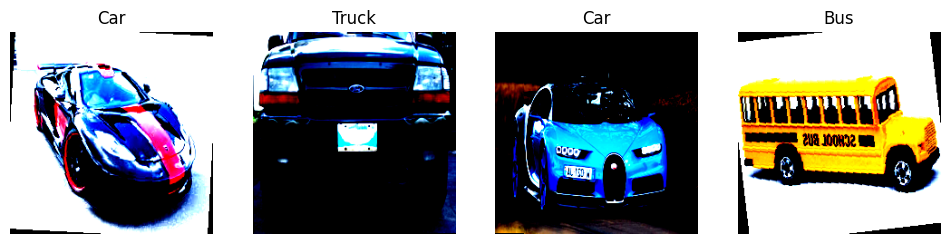

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.data_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# Augumentare a datelor
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Instantiere pt datasetul de antrenare
train_dataset = CustomDataset(data_dir="/content/drive/My Drive/SI/Proiect/dataset/Dataset", transform=data_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

import matplotlib.pyplot as plt

# Extrage un lot de date de antrenare
images, labels = next(iter(train_dataloader))

# Afis primele 4 imagini din lot
plt.figure(figsize=(12, 6)) #creez o fig matplot cu o dim de 12x6 inch
for i in range(4):
    plt.subplot(1, 4, i + 1) #o sg linie 4 coloane,i+1 se refera la nr subplotului actual
    plt.imshow(images[i].permute(1, 2, 0)) #se afis imag curenta
    plt.title(train_dataset.classes[labels[i]]) #adaugam titlu fiecarui subplot care defapt e numele clasei coresp etichetei imaginii
    plt.axis('off')
plt.show()


In acest cod incepem cu definirea unei transformari pentru preprocesare. Aceasta transformare are: resize,totensor si normalize.
Dupa care vom crea un nou dataset utilizand aceasta transformare de preprocesare si vom face un dataloader pt datasetul preprocesat.
Apoi vom calcula media si deviatia standard a imaginilor din setul de date preprocesat. Acestea doua se calculeaza iterand prin fiecare lot de date din dataloader-ul preprocesat si calculand nr de imagini din fiecare lot,suma mediei,suma deviatiei si la final impartind fiecare suma la nr total de imagini.
Dupa care vom afisa histograma pt distributia pixelilor folosind functia hist().
Mai apoi vom afisa distrubtia claselor in setul de date. Se itereaza prin fiecare imagine din setul de date preprocesat si se numara cate imagini exista pentru fiecare clasa.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Mean: tensor([-0.0056,  0.0308,  0.1837])
Standard Deviation: tensor([1.1696, 1.1750, 1.2037])


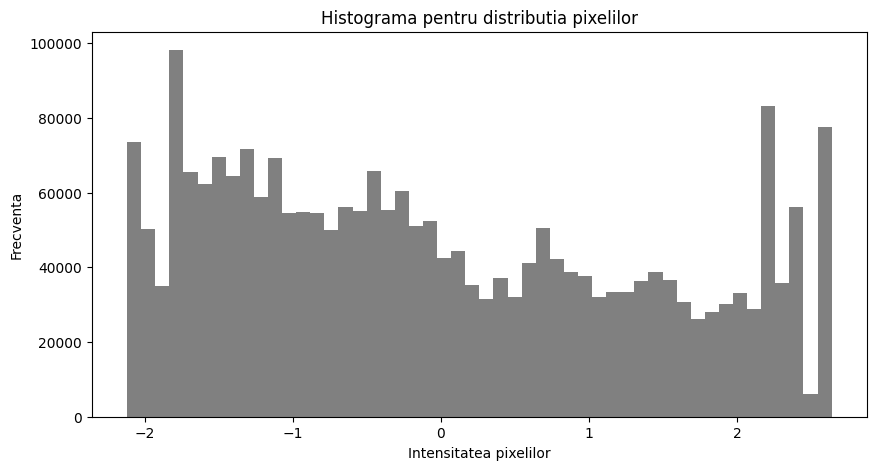

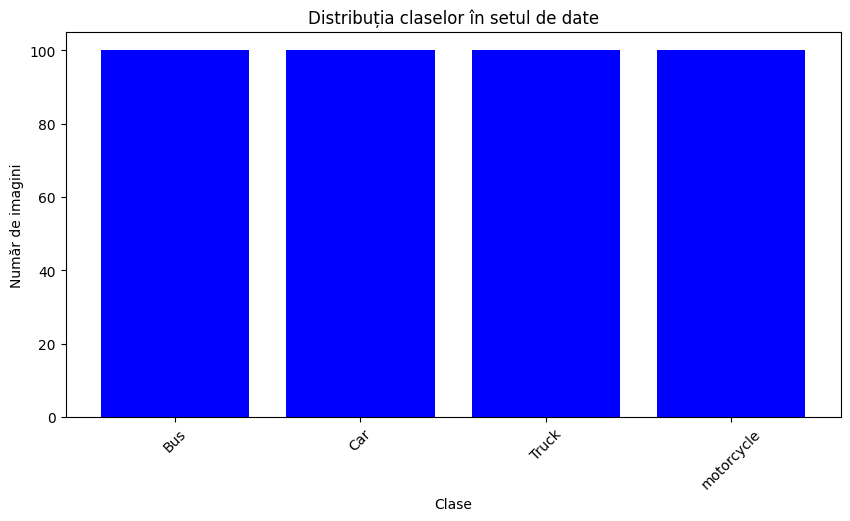

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Transformare pt preprocesare care normalizeaza imaginile
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Nou dataset cu transformarea de preprocesare
preprocessed_dataset = CustomDataset(data_dir="/content/drive/My Drive/SI/Proiect/dataset/Dataset", transform=preprocess)

preprocessed_dataloader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

#Media si deviatia standard
mean = torch.zeros(3) #initializez un tensor de dim 3(pt cele 3 canale rgb) cu 0
std_dev = torch.zeros(3) #suma deviatiei standard
total_samples = 0 #nr total de imagini

for images, _ in preprocessed_dataloader:
    batch_size = images.size(0) #obtin dim lotului(nr de imagini din lot)
    images = images.view(batch_size, images.size(1), -1) #tratez fiecare canal ca o dim separata, -1=o dim calc automat pt a pastra toti pixelii
    mean += images.mean(2).sum(0)
    std_dev += images.std(2).sum(0)
    total_samples += batch_size

mean /= total_samples
std_dev /= total_samples

print("Mean:", mean)
print("Standard Deviation:", std_dev)

# Histograma
plt.figure(figsize=(10, 5)) #creeaza o fig matplotlib cu o dim 10x5 inch
plt.title("Histograma pentru distributia pixelilor")
plt.hist(images.numpy().ravel(), bins=50, color='gray') #converteste tensorul de imagini intr-un sir numpy si il aplatizeaza,
#bins=nr de benzi,specifica nr de bucati in care se imparte intervalul de valori al pixelilor pentru a calcula frecventa lor
plt.xlabel("Intensitatea pixelilor")
plt.ylabel("Frecventa")
plt.show()

# Distributia claselor in setul de date
class_distribution = [0] * len(preprocessed_dataset.classes) #initializeaza o lista de frecvente cu lungimea numarului
# de clase din setul de date cu 0
for _, label in preprocessed_dataset:
    class_distribution[label] += 1

plt.figure(figsize=(10, 5))
plt.title("Distribuția claselor în setul de date")
plt.bar(preprocessed_dataset.classes, class_distribution, color='blue') #deseneaza graficul folosind clasele si frecventele
plt.xlabel("Clase")
plt.ylabel("Număr de imagini")
plt.xticks(rotation=45)
plt.show()


In aceasta bucata de cod defineste o noua clasa care este o subclasa a lui nn.Module. Initializam constructorul,apelam constructorul clasei parinte, initializam un backbone de retea neurala folosind arhitectura ResNet-18 preantrenata disponibila în torchvision(acesta va fi utilizat pentru extragerea caracteristicilor din imagini), apoi obtinem nr de caracteristici de intrare ale stratului complet conectat din backbone-ul resnet. Apoi vom inlocui stratul complet conectat existent din backbone cu un nou strat complet conectat. Metoda forward defineste modul in care datele sunt propagate prin reteaua neurala.
Dupa vom instantia modelul pt setul de date de antrenare, dar mai intai vom calcula nr de clase al setului de antrenare

In [ ]:
import torch.nn as nn
import torchvision.models as models

class VehicleRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(VehicleRecognitionModel, self).__init__()
        # backbone ResNet preantrenat
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes) #inlocuim stratul complet conectat existent din backbone cu un nou strat complet conectat

    def forward(self, x):
        x = self.backbone(x) #aplicam backbone-ul pe x + se calculeaza iesirea retelei neuronale
        return x
num_classes = len(train_dataset.classes)
# Cream o instanta a modelului
model = VehicleRecognitionModel(num_classes)
print(model) #se afis modelul(care defapt e o reprezentare a arhitecturii si a parametrilor). Aceasta va afisa si arhitectura backbone-ului ResNet-18,
#cu modificarile aduse stratului complet conectat pentru clasificare in cele num_classes clase.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.7MB/s]


VehicleRecognitionModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In aceasta bucata de cod incepem prin a fi defini o transformare preprocess care redimensioneaza imaginile, le converteste in tensori si le normalizeaza conform mediei si deviatiei standard.
Apoi definesc o clasa KaggleCustomDataset care incarca imag si etichetele coresp si le aplica transformarea definita mai sus.
Dupa acestea se incepe impartirea setului de date.
Aproximativ 80% din setul de date este alocat pt antrenare(train_size) si restul pt testare(test_size). Apoi impartim setul de date personalizat in 2 subseturi:antrenare si validare. Apoi vom crea data loader pt seturile de antrenare si validare.
Apoi definesc clasa VehicleRecognitionModel care defineste modelul pt recunoastearea vehiculelor. Metoda forward defineste ca datele sunt propagate prin arhitectura de baza si rezultatul este returnat.
Apoi continui cu instantierea modelului si mutarea acestuia dispozitivul disponibil(gpu sau cpu).
Continui cu configurarea fct de loss si a optimizerului. Folosesc optimizerul Adam care este un optimizer eficient si adesea folosit pentru antrenarea retelelor neuronale. Parametrul lr=0.001 specifica rata de invatare (learning rate) pentru optimizer.
In continuare am definit o fct train_model care e folosita pentru antrenarea si evaluarea modelului pe seturile de date de antrenare si de validare. Am definit 10 epoci si pt fiecare epoca modelul este setat pt antrenare. Apoi iteram dataloader-ul de antrenare si pt fiecare lot de date se fac urmatoarele:se muta datele si etichetele pe dispozitivul specificat, se reseteaza gradientii parametrilor modelului la 0, se calculeaza iesirile modelului pt datele de intrare,se calculeaza loss-ul pentru predictiile modelului comparandu-le cu etichetele reale folosind functia de loss specificata(criterion),se efectueaza back propagation pt calculul gradientilor, se actualizeaza parametrii modelului folosind optimizerul si se calculeaza loss-ul mediu pe lotul curent si se adauga la pierderea totala pt epoca(running_train_loss). La finalul fiecarei epoci pierderea medie este calculata impartind pierderea totala/nr de exemple de antrenare.
Mai departe dupa ce antrenarea pe o epoca este completa modelul este setat in modul de evaluare. Se itereaza prin dataloader-ul de validare si se face acelasi lucru ca la antrenare, doar ca aici se calculeaza la finalul fiecarei epoci pierderea medie pentru epoca de validare.
Apoi dupa fiecare epoca pierderile de antrenare si de validare sunt afisate pentru a monitoriza progresul antrenamentului.
Dupa ce antrenarea este completa, pierderile de antrenare si de validare sunt plotate intr-un grafic pentru a vizualiza cum evolueaza acestea in timpul antrenamentului.

Epoch 1/10, Train Loss: 0.7369, Val Loss: 4.1173
Epoch 2/10, Train Loss: 0.1816, Val Loss: 5.4561
Epoch 3/10, Train Loss: 0.0791, Val Loss: 1.4979
Epoch 4/10, Train Loss: 0.0485, Val Loss: 2.5889
Epoch 5/10, Train Loss: 0.0308, Val Loss: 0.8843
Epoch 6/10, Train Loss: 0.0165, Val Loss: 0.4100
Epoch 7/10, Train Loss: 0.0099, Val Loss: 0.3739
Epoch 8/10, Train Loss: 0.0038, Val Loss: 0.3370
Epoch 9/10, Train Loss: 0.0070, Val Loss: 0.3141
Epoch 10/10, Train Loss: 0.0020, Val Loss: 0.2912


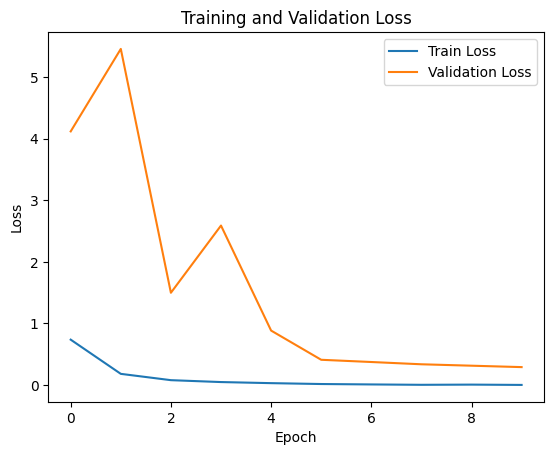

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class KaggleCustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        self.images = []
        self.labels = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): #utilizata pt a accesa un elem din setul de date folosind un index specificat
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

dataset_root = "/content/drive/My Drive/SI/Proiect/dataset/Dataset"

custom_dataset = KaggleCustomDataset(root_dir=dataset_root, transform=preprocess)

#Dimensiunea setului de date de antrenare+testare
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [train_size, test_size])

#Dataloaderele setului de date de antrenare+validare
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

#Modelul pt recunoasterea vehiculelor
class VehicleRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(VehicleRecognitionModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x

num_classes = len(custom_dataset.classes) #nr de clase din setul de date personalizat
model = VehicleRecognitionModel(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #mutarea modelului pe dispozitivul disponibil
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# sa adaug regularizare

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Antrenare
        model.train()
        running_train_loss = 0.0 # acumuleaza pierderea totala in timpul unei epoci de antrenament
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) #datele si etichetele
            optimizer.zero_grad() #initializam gradientii parametrilor modelului la 0
            outputs = model(inputs) #se calc iesirile modelului pt datele de intrare curente
            loss = criterion(outputs, labels) #se calc loss-ul pt iesire prezise si etichetele reale
            loss.backward() #back propagation pt calculul gradientilor
            optimizer.step() #se actualizeaza parametrii modelului folosind optimizerul
            running_train_loss += loss.item() * inputs.size(0) #se calculeaza loss-ul mediu pe lotul curent si
            #se adauga la pierderea totala pt epoca(running_train_loss)
        epoch_train_loss = running_train_loss / len(train_loader.dataset) #pierderea medie
        train_losses.append(epoch_train_loss)

        # Validare
        model.eval() #modelul este setat in modul de evaluare
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset) #pierderea medie pentru epoca de validare
            val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

# Antrenam modelul si salvam pierderile pentru plotare
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Acest cod defineste o retea neurala convolutionala bazata pe modelul ResNet pentru recunoasterea vehiculelor, cu adaugarea unei functii de activare ReLU si antrenarea acesteia folosind date de antrenare si de validare.

VehicleRecognitionModelReLU(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

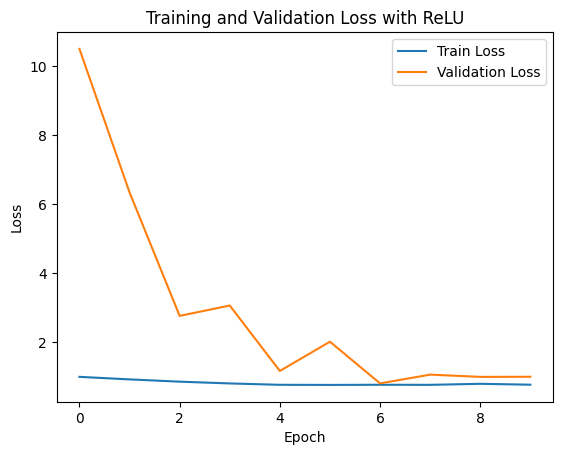

In [ ]:
import torch.nn.functional as F

class VehicleRecognitionModelReLU(nn.Module):
    def __init__(self, num_classes):
        super(VehicleRecognitionModelReLU, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)
        x = F.relu(x) #adaug Relu
        return x

model_relu = VehicleRecognitionModelReLU(num_classes)
print(model_relu)

model_relu.to(device)

optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=0.001)
criterion_relu = nn.CrossEntropyLoss()

train_losses_relu, val_losses_relu = train_model(model_relu, train_loader, val_loader, criterion_relu, optimizer_relu, num_epochs=10)

plt.plot(train_losses_relu, label='Train Loss')
plt.plot(val_losses_relu, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with ReLU')
plt.legend()
plt.show()


Aceasta bucata de cod defineste o fct care se ocupa cu antrenarea si evaluarea modelului pe seturile de date de antrenare si de validare, folosind un scheduler pentru ajustarea ratei de invatare in timpul antrenamentului. Aceasta fct este similara cu train_model doar ca se adauga un scheduler. Scheduler-ul se aplica la fiecare epoca incepand cu a doua jumatate a numarului total de epoci specificat. Scheduler-ul este utilizat pentru a ajusta rata de invatare a optimizerului in timpul antrenamentului, ceea ce poate ajuta la obtinerea unei convergente mai rapide sau la evitarea supraantrenarii.
Apoi se face configurarea scheduler-ului,unde step_size se refera la numarul de epoci dupa care se aplica o reducere a ratei de invatare,iar gamma specifica factorul cu care se reduce rata de invatare. În acest caz, rata de invatare este redusa cu un factor de 0.1 la fiecare etapa.
Apoi va trebui ca acest scheduler sa fie antrenat folosind fct definita mai sus. Scheduler-ul este aplicat in mod automat de la a doua jumatate a antrenamentului. In acest exemplu, numarul total de epoci este dublu fata de numarul de epoci pe care dorim sa aplicam scheduler-ul, deoarece antrenamentul este impartit in doua etape, fiecare cu num_epochs_per_stage epoci.
Dupa antrenarea modelului cu scheduler-ul, pierderile de antrenare si de validare sunt plotate intr-un grafic.

Epoch 1/10, Train Loss: 2.3462, Val Loss: 14992.8676
Epoch 2/10, Train Loss: 1.6365, Val Loss: 1051.4836
Epoch 3/10, Train Loss: 1.4785, Val Loss: 97.5138
Epoch 4/10, Train Loss: 1.3051, Val Loss: 22.8776
Epoch 5/10, Train Loss: 1.2772, Val Loss: 3.6327
Epoch 6/10, Train Loss: 1.2787, Val Loss: 1.3642
Epoch 7/10, Train Loss: 1.0729, Val Loss: 1.1600
Epoch 8/10, Train Loss: 1.0625, Val Loss: 1.1510
Epoch 9/10, Train Loss: 1.0275, Val Loss: 1.1542
Epoch 10/10, Train Loss: 1.0121, Val Loss: 1.1713


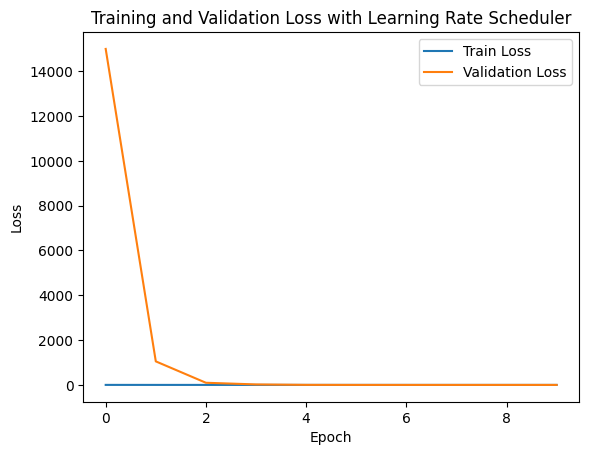

In [ ]:
#Fct de antrenare cu scheduler
def train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Antrenare
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validare
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Aplicam scheduler-ul la fiecare epoca din a doua jumatate a antrenamentului
        if epoch >= num_epochs // 2:
            scheduler.step()

    return train_losses, val_losses

#Nr de epoci pentru fiecare etapa
num_epochs_per_stage = 5

#Modelul, criteriul, optimizerul, scheduler-ul
model = VehicleRecognitionModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # Reduc learning rate-ul cu un factor de 0.1 la fiecare epoca

# Antrenam modelul folosind functia de antrenare cu scheduler
train_losses, val_losses = train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs_per_stage * 2)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Learning Rate Scheduler')
plt.legend()
plt.show()


In aceasta bucata de cod definesc mai intai functiile de pierdere: Cross Entropy si Kullback-Leibler Divergence Loss.
In clasa care defineste Cross Entropy am constructorul in care se initializeaza obiectul de fct de pierdere self.loss_fn cu nn.CrossEntropyLoss(), care este fct de pierdere standard de entropie incrucisata din PyTorch. In metoda forward
se apeleaza self.loss_fn pentru a calcula pierderea Cross Entropy intre iesirile modelului si etichetele reale si se returneaza rezultatul.
Cealalta clasa care defineste Kullback-Leibler Divergence Loss este identica cu cea anterioara, insa cu cateva diferente. In constructorul acestei clase se initializeaza obiectul cu nn.LogSoftmax(dim=1) care caluleaza log din softmax pt a obtine log probabilitatilor normalizate. In metoda forward se calculeaza log prob normalizate pentru iesirile modelului, apoi se initializeaza tensorul targets cu dimensiunea si tipul similar cu log_probs, apoi se foloseste fct scatter_ pentru a seta valorile coresp etichetelor reale la 1, restul raman pe 0. Apoi se apeleaza si se calculeza pierderea folosint KL Divergence intre log_probs si targets.
Mai apoi definesc fct de antrenare.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Definesc fct de pierdere
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, outputs, labels):
        return self.loss_fn(outputs, labels)

class CustomKLDivergenceLoss(nn.Module):
    def __init__(self):
        super(CustomKLDivergenceLoss, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, outputs, labels):
        log_probs = self.log_softmax(outputs)
        targets = torch.zeros_like(log_probs)
        targets.scatter_(1, labels.unsqueeze(1), 1)
        return nn.KLDivLoss()(log_probs, targets)

#Fct de antrenare care va fi folosita pt testarea fiecarei fct de pierdere
def train_model_with_loss_function(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


In [ ]:
dataset_root = "/content/drive/My Drive/SI/Proiect/dataset/Dataset"
custom_dataset = KaggleCustomDataset(root_dir=dataset_root, transform=preprocess)

train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:

num_classes = len(custom_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VehicleRecognitionModel(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Fct de pierdere
cross_entropy_loss_fn = CustomCrossEntropyLoss()
kl_divergence_loss_fn = CustomKLDivergenceLoss()

# Antrenam modelul cu Cross Entropy Loss
train_losses_ce, val_losses_ce = train_model_with_loss_function(model, train_loader, val_loader, cross_entropy_loss_fn, optimizer, num_epochs=num_epochs)

# Antrenam modelul cu Kullback-Leibler Divergence Loss
train_losses_kl, val_losses_kl = train_model_with_loss_function(model, train_loader, val_loader, kl_divergence_loss_fn, optimizer, num_epochs=num_epochs)


Epoch 1/10, Train Loss: 0.7241, Val Loss: 14.4134
Epoch 2/10, Train Loss: 0.3805, Val Loss: 3.5860
Epoch 3/10, Train Loss: 0.1595, Val Loss: 5.1698
Epoch 4/10, Train Loss: 0.0943, Val Loss: 0.7680
Epoch 5/10, Train Loss: 0.0335, Val Loss: 0.5250
Epoch 6/10, Train Loss: 0.0096, Val Loss: 0.6394
Epoch 7/10, Train Loss: 0.0296, Val Loss: 0.7100
Epoch 8/10, Train Loss: 0.0495, Val Loss: 0.8069
Epoch 9/10, Train Loss: 0.0641, Val Loss: 1.0706
Epoch 10/10, Train Loss: 0.0747, Val Loss: 0.5139


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/10, Train Loss: 0.0160, Val Loss: 0.1764
Epoch 2/10, Train Loss: 0.0113, Val Loss: 0.1718
Epoch 3/10, Train Loss: 0.0081, Val Loss: 0.1315
Epoch 4/10, Train Loss: 0.0040, Val Loss: 0.1215
Epoch 5/10, Train Loss: 0.0025, Val Loss: 0.1226
Epoch 6/10, Train Loss: 0.0014, Val Loss: 0.1120
Epoch 7/10, Train Loss: 0.0008, Val Loss: 0.1023
Epoch 8/10, Train Loss: 0.0007, Val Loss: 0.0935
Epoch 9/10, Train Loss: 0.0006, Val Loss: 0.0952
Epoch 10/10, Train Loss: 0.0014, Val Loss: 0.1074


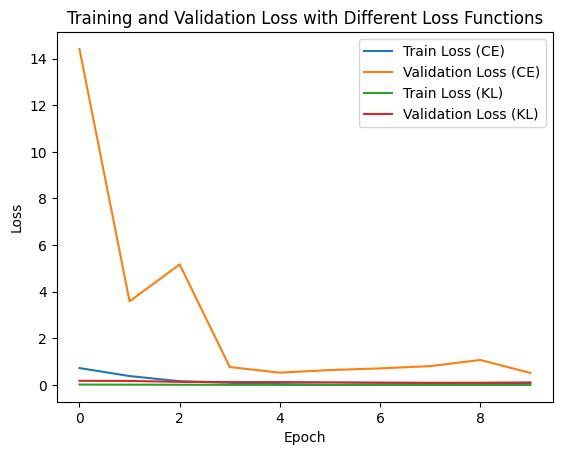

In [ ]:
plt.plot(train_losses_ce, label='Train Loss (CE)')
plt.plot(val_losses_ce, label='Validation Loss (CE)')

plt.plot(train_losses_kl, label='Train Loss (KL)')
plt.plot(val_losses_kl, label='Validation Loss (KL)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Different Loss Functions')
plt.legend()
plt.show()


In aceasta bucata de cod vom calcula acuratetea, recall-ul si vom afisa matricea de confuzie.
Mai intai am definit o functie evaluate_model care primeste modelul si un dataloader pt a evalua performanta modelului pe datele de validare.
Mai departe functia plot_confusion_matrix e destinata afisarii matricii de confuzie si primeste matricea de confuzie si numele claselor.
Se parcurg toate elementele din matricea de confuzie si pt fiecare element se adauga textul valorii respective. Acest text este pus in centrul fiecarei celule si e colorat in alb sau negru in fct de valoarea acestuia. Mai departe convertim figura in tensor si o returnam.


Accuracy: 0.875
Recall: 0.875
Confusion Matrix:
[[24  0  2  0]
 [ 1  8  1  0]
 [ 2  0 16  0]
 [ 0  0  4 22]]


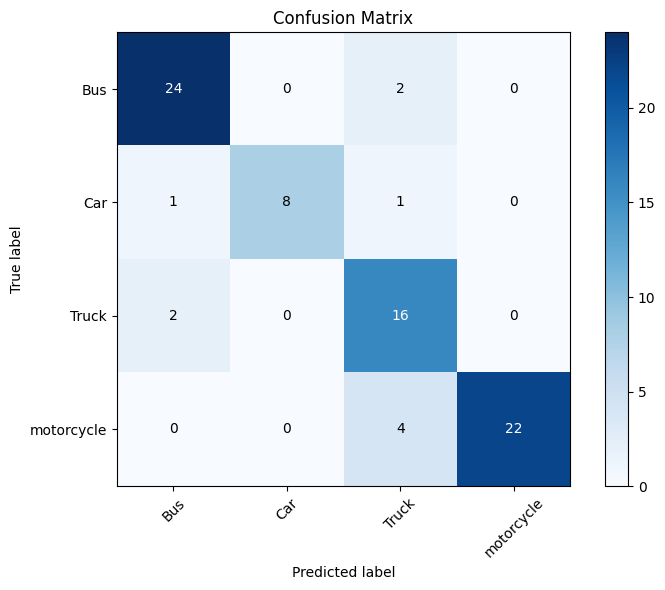

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

# Calcularea metricilor si generarea matricei de confuzie
def evaluate_model(model, data_loader):
    model.eval()
    y_true = [] #etichetele reale
    y_pred = [] #etichetele prezise
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) #etichetele prezise sunt obtinute prin gasirea val maxime pe fiecare linie din iesirile modelului
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    confusion = confusion_matrix(y_true, y_pred)

    return accuracy, recall, confusion

# Fct pentru vizualizarea matricei de confuzie si convertirea sa intr-un tensor
def plot_confusion_matrix(confusion, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar() #se adauga o bara de culoare pt a afisa echivalenta intre culorile din imagine si valorile din matricea de confuzie
    tick_marks = np.arange(len(class_names))
    #marcajele pt axele x si y coresp numelor claselor
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = confusion.max() / 2.
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.text(j, i, format(confusion[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if confusion[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Convertim figura Matplotlib intr-un tensor si o returnam
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf)
    tensor = transforms.ToTensor()(image)
    buf.close()
    return tensor

accuracy, recall, confusion = evaluate_model(model, val_loader)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion Matrix:")
print(confusion)

# Salvarea matricei de confuzie in TensorBoard
writer = SummaryWriter()
confusion_image = plot_confusion_matrix(confusion, class_names=train_dataset.dataset.classes)
writer.add_image("Confusion Matrix", confusion_image, global_step=0)
writer.close()


Acest cod implementeaza o bucla de antrenare si evaluare a unui model de recunoastere a vehiculelor utilizand diferiti optimizatori, precum SGD, Adam si RMSprop.
Pentru fiecare optimizator in parte vom afisa loss-ul si acuratetea finala.

In [ ]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Antrenarea
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validare
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

optimizers_to_test = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
    "RMSprop": optim.RMSprop
}

# Rez care cuprind loss-ul si acuratetea finala
experiment_results = {}

for optimizer_name, optimizer_class in optimizers_to_test.items():
    print(f"Experimenting with optimizer: {optimizer_name}")

    model = VehicleRecognitionModel(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=0.001)

    # Antrenarea modelului pe setul de date de antrenare
    train_losses, _ = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    # Evaluarea modelului pe setul de date de validare
    accuracy, _, _ = evaluate_model(model, val_loader)

    # Salvarea rezultatelor
    experiment_results[optimizer_name] = {
        "train_losses": train_losses,
        "accuracy": accuracy
    }

for optimizer_name, results in experiment_results.items():
    print(f"Optimizer: {optimizer_name}")
    print(f"Final Accuracy: {results['accuracy']}")


Experimenting with optimizer: SGD


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Train Loss: 1.5383, Val Loss: 1.4467
Epoch 2/10, Train Loss: 1.3086, Val Loss: 1.2319
Epoch 3/10, Train Loss: 1.1609, Val Loss: 1.0968
Epoch 4/10, Train Loss: 1.0487, Val Loss: 0.9935
Epoch 5/10, Train Loss: 0.9325, Val Loss: 0.9009
Epoch 6/10, Train Loss: 0.8412, Val Loss: 0.8275
Epoch 7/10, Train Loss: 0.7586, Val Loss: 0.7681
Epoch 8/10, Train Loss: 0.7070, Val Loss: 0.7133
Epoch 9/10, Train Loss: 0.6754, Val Loss: 0.6689
Epoch 10/10, Train Loss: 0.6238, Val Loss: 0.6292
Experimenting with optimizer: Adam


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Train Loss: 0.6682, Val Loss: 17.1938
Epoch 2/10, Train Loss: 0.3395, Val Loss: 7.6479
Epoch 3/10, Train Loss: 0.1762, Val Loss: 0.9240
Epoch 4/10, Train Loss: 0.1127, Val Loss: 0.5344
Epoch 5/10, Train Loss: 0.1501, Val Loss: 2.8218
Epoch 6/10, Train Loss: 0.0410, Val Loss: 0.7451
Epoch 7/10, Train Loss: 0.0516, Val Loss: 0.4272
Epoch 8/10, Train Loss: 0.0519, Val Loss: 0.5140
Epoch 9/10, Train Loss: 0.0130, Val Loss: 0.5699
Epoch 10/10, Train Loss: 0.0209, Val Loss: 0.4799
Experimenting with optimizer: RMSprop


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Train Loss: 2.2502, Val Loss: 473.8544
Epoch 2/10, Train Loss: 1.6369, Val Loss: 7.5766
Epoch 3/10, Train Loss: 1.4147, Val Loss: 2.8903
Epoch 4/10, Train Loss: 1.3692, Val Loss: 1.9344
Epoch 5/10, Train Loss: 1.3564, Val Loss: 1.3962
Epoch 6/10, Train Loss: 1.3078, Val Loss: 1.4358
Epoch 7/10, Train Loss: 1.2424, Val Loss: 1.4381
Epoch 8/10, Train Loss: 1.1697, Val Loss: 1.5182
Epoch 9/10, Train Loss: 1.1329, Val Loss: 1.3466
Epoch 10/10, Train Loss: 1.0584, Val Loss: 1.9298
Optimizer: SGD
Final Accuracy: 0.8625
Optimizer: Adam
Final Accuracy: 0.85
Optimizer: RMSprop
Final Accuracy: 0.45


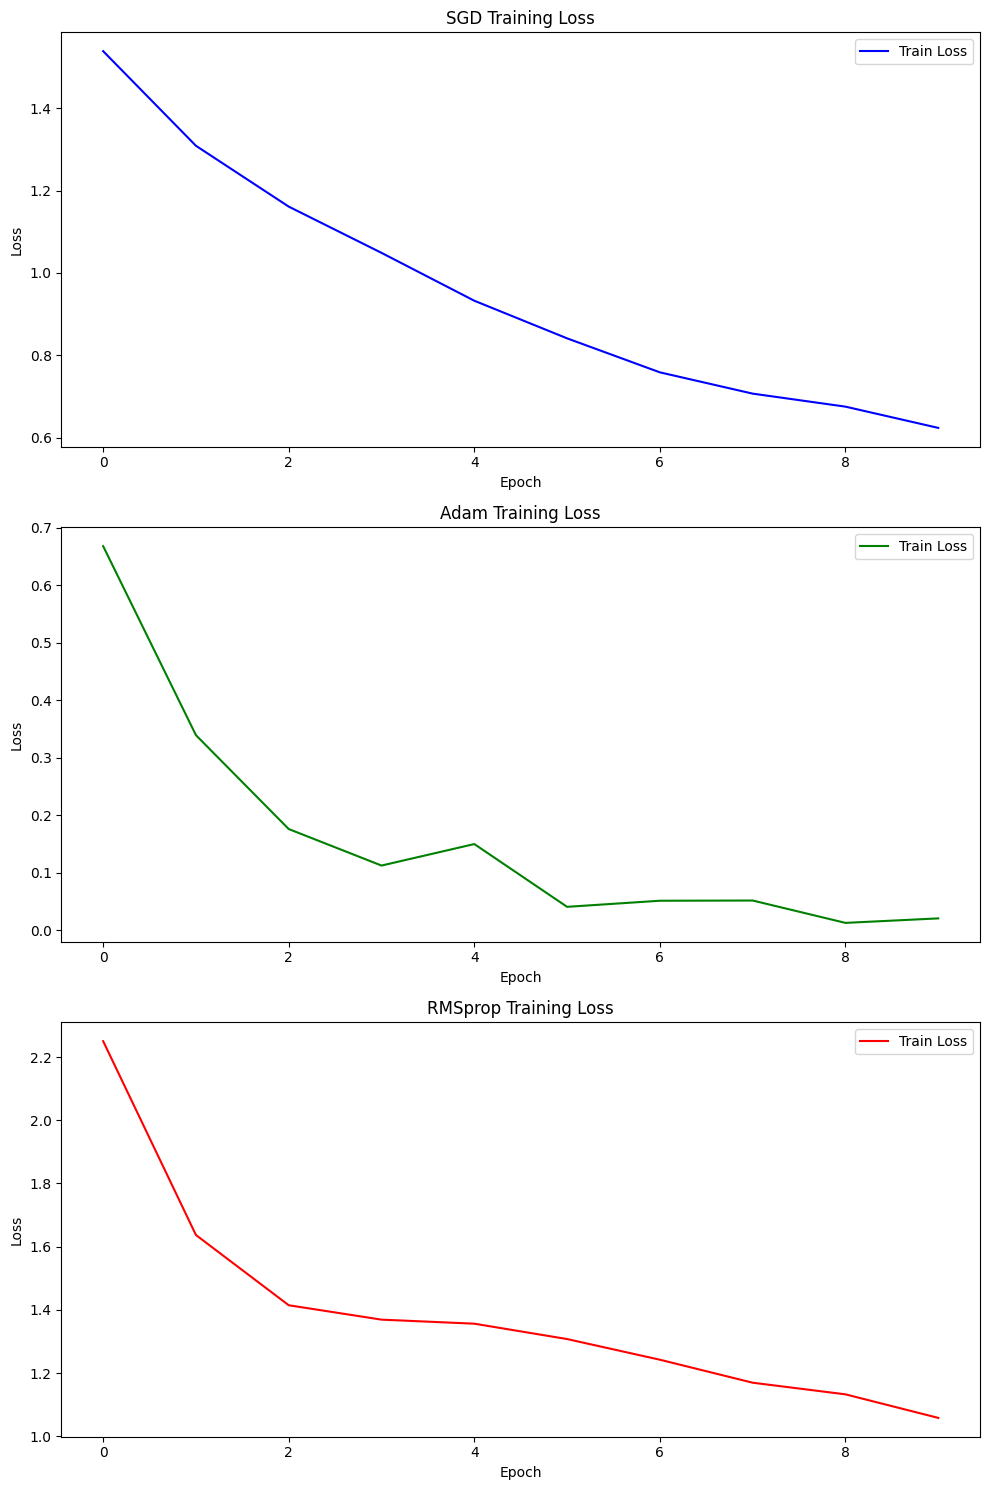

In [ ]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, (optimizer_name, results) in enumerate(experiment_results.items()):
    axes[i].plot(results['train_losses'], label='Train Loss', color=colors[i])
    axes[i].set_title(f'{optimizer_name} Training Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

plt.tight_layout()
plt.show()
